## Семинар 8: "Снижение размерности"

ФИО: Устинов Иван Вадимович

In [1]:
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
from torch.autograd import Variable
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

/home/ivan.ustinov/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Этот семинар посвящен снижению размерности на примере данных Olivetti faces. В данных содержатся 400 черно-белых изображений 64x64. Требуется исследовать различные способы снижения размерности: PCA и Автокодировщик

In [2]:
X = fetch_olivetti_faces()['data']

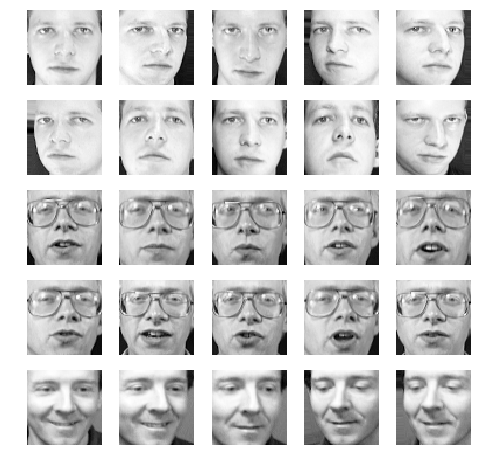

In [4]:
plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

### Часть 1: PCA

In [3]:
from sklearn.decomposition import PCA

<i> 1.1 Примените алгоритм PCA к данным и отобразите главные компоненты. В качестве числа компонент выберите 25</i>

Подсказка: используйте метод <b>.components_</b>

In [5]:
trans = PCA(n_components=25)
trans.fit(X)

PCA(copy=True, iterated_power='auto', n_components=25, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

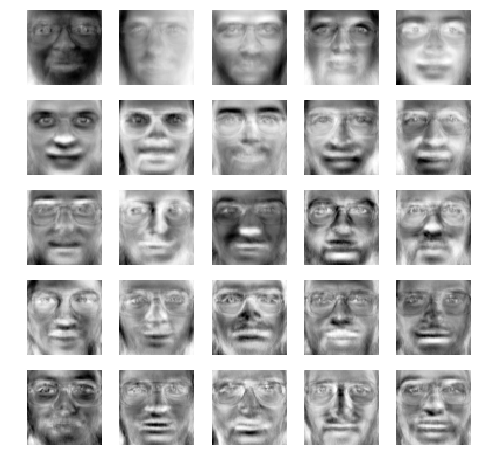

In [6]:
plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(trans.components_[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

<i> 1.2 Отобразите зависимость качества восстановления от количества компонент</i>

Подсказка: используйте методы <b>.explained\_variance\_ratio\_</b> и <b>np.cumsum()</b>

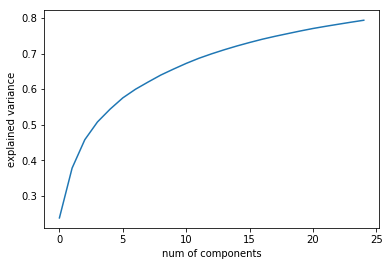

In [19]:
accuracy = [np.cumsum(trans.explained_variance_ratio_[:i+1])[i] for i in range(25)]
# np.cumsum(trans.explained_variance_ratio_[:1])[0]
plt.plot(accuracy)
plt.xlabel("num of components")
plt.ylabel("explained variance")
plt.legend()

<i>1.3 Какое количество компонент следует выбирать, чтобы соблюсти баланс размерность — качество?</i>

Примерно в 6 компонентах находится ноль второй производной (на глаз).

После 6 объясненная дисперсия начинает быстро падать.

Но при 6 получилось совсем не очень, при 10 хоть какие-то детали выделяются

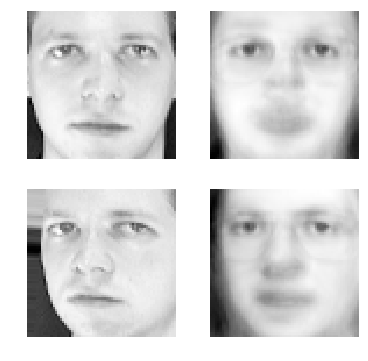

In [21]:
trans_6 = PCA(n_components=10)
embed = trans_6.fit_transform(X)
reconstr = trans_6.inverse_transform(embed)

plt.figure(figsize=(6, 6))
plt.subplot(2, 2, 1)
plt.imshow(X[0].reshape(64, 64), cmap=plt.cm.Greys_r)
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(reconstr[0].reshape(64, 64), cmap=plt.cm.Greys_r)
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(X[5].reshape(64, 64), cmap=plt.cm.Greys_r)
plt.axis('off')
plt.subplot(2, 2, 4)
plt.imshow(reconstr[5].reshape(64, 64), cmap=plt.cm.Greys_r)
plt.axis('off')
plt.show()

<i>1.4 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют? Чему соответствуют главные компоненты?</i>

In [17]:
# Код для отображения изображений в 2D
def plot_dataset(X, emb, margin=50, frame=2000., imsize=64):
    assert(emb.shape[1] == 2)
    emb = np.array((emb - emb.min(0)) * (frame / (emb.max(0) - emb.min(0))) + margin, dtype = np.int)
    image = np.zeros((int(emb[:, 0].max() + margin + imsize), int(emb[:, 1].max() + margin + imsize))) + 1
    for k in range(X.shape[0]):
        image[emb[k, 0]:emb[k, 0]+64, emb[k, 1]:emb[k, 1]+64] = X[k].reshape(64, 64)
    plt.figure(figsize=(20, 20))
    plt.imshow(image, cmap="Greys_r")
    plt.axis("off")
    plt.show()

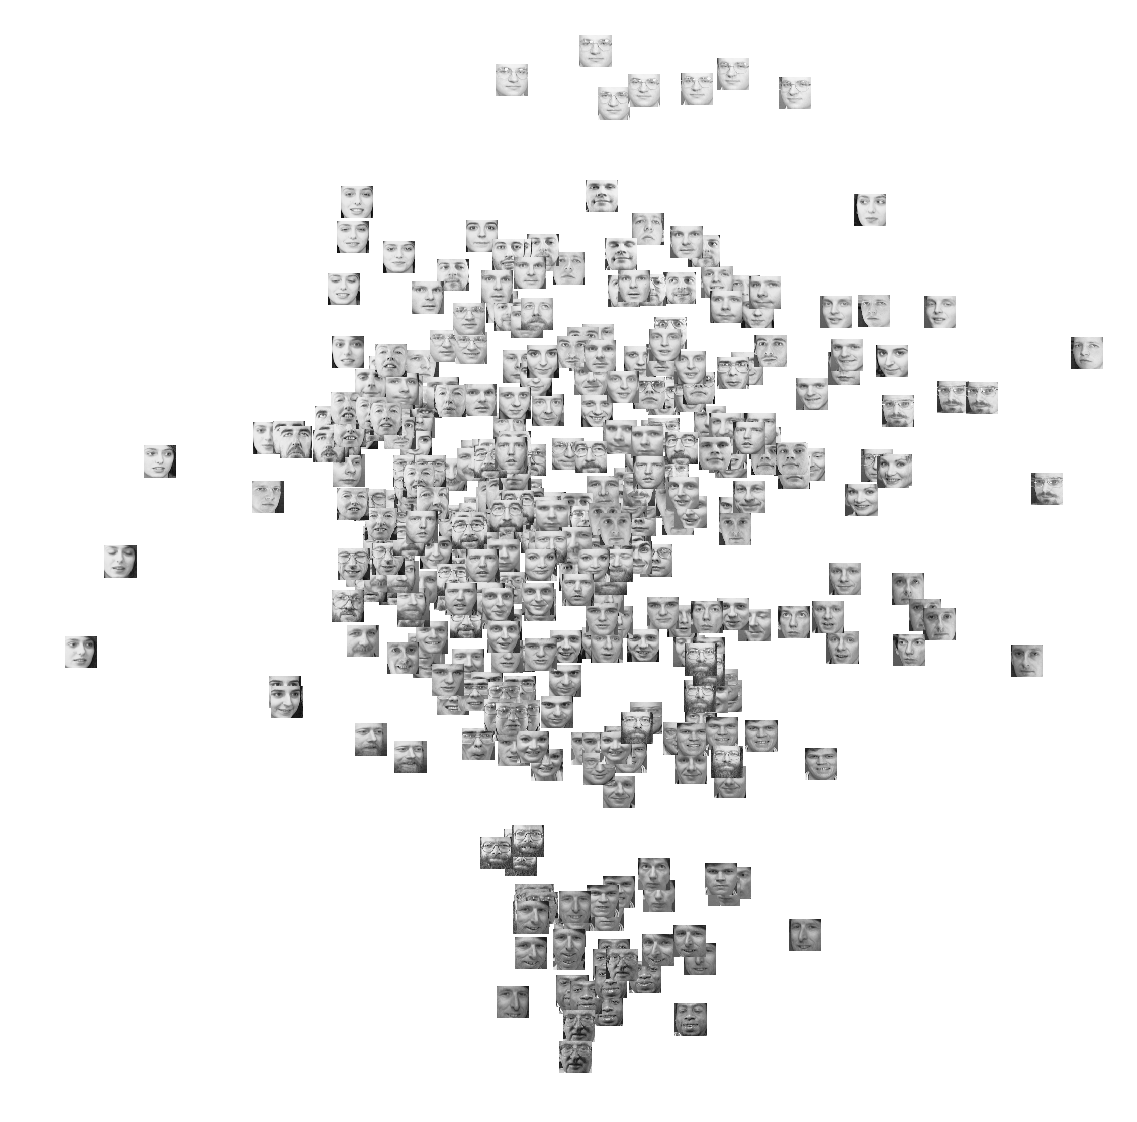

In [27]:
trans_2 = PCA(n_components=2)
X_new_2 = trans_2.fit_transform(X)
plot_dataset(X, X_new_2)

Вцелом всё находится в куче, но если присмотреться, то локально лица людей что-то объединяет, и они достаточно похожи. Т.е. существуют видимые причины, почему картинки между собой оказываются рядом.

###  Часть 2: Автокодировщик

<i> 2.1 Обучите автокодировщик с архитектурой 4096 -> 200 -> 10 -> 200 -> 4096. В качестве нелинейностей используйте сигмоиду.</i>

In [4]:
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [5]:
class CustomLoader(Dataset):
    def __init__(self, X):
        super(CustomLoader, self).__init__()
        self.data = np.array(X)
    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self, idx):
        return self.data[idx]
    
data_ = CustomLoader(X)
dataloader = DataLoader(data_, batch_size=32)

In [30]:
encoder = nn.Sequential(nn.Linear(4096, 200), nn.Linear(200, 10))
decoder = nn.Sequential(nn.Linear(10, 200), nn.Linear(200, 4096))
params = list(encoder.parameters()) + list(decoder.parameters())
opt = optim.Adam(params=params, lr=0.002)
loss_func = nn.MSELoss()
epoch = 100
losses = []

for e in tqdm(range(epoch)):
    for batch in dataloader:
        x = Variable(torch.FloatTensor(batch))
        y = Variable(torch.FloatTensor(batch), requires_grad=False)
        
        x_pred = encoder(x)
        y_pred = decoder(x_pred)
        
        loss = loss_func(y_pred, y)
        losses.append(np.array(loss.data))
        opt.zero_grad()
        loss.backward()
        opt.step()

100%|██████████| 100/100 [01:09<00:00,  1.67it/s]


<i> 2.2 Какое качество восстановления удалось получить?</i>

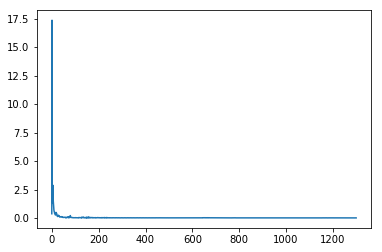

In [31]:
plt.plot(losses)

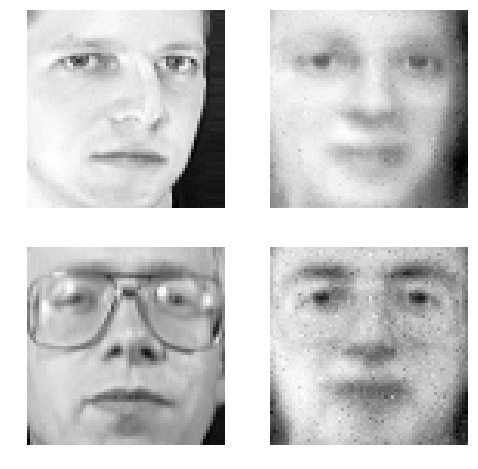

In [40]:
idx = 1
x_enc = encoder(Variable(torch.FloatTensor(data_[idx])))
x_dec = decoder(x_enc)

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.imshow(data_[idx].reshape(64, 64), cmap=plt.cm.Greys_r)
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(np.array(x_dec.data).reshape(64, 64), cmap=plt.cm.Greys_r)
plt.axis('off')

x_enc = encoder(Variable(torch.FloatTensor(data_[idx+10])))
x_dec = decoder(x_enc)

plt.subplot(2, 2, 3)
plt.imshow(data_[idx+10].reshape(64, 64), cmap=plt.cm.Greys_r)
plt.axis('off')
plt.subplot(2, 2, 4)
plt.imshow(np.array(x_dec.data).reshape(64, 64), cmap=plt.cm.Greys_r)
plt.axis('off')
plt.show()

На мой взгляд получилось плоховато.

<i> 2.3 Обучите сеть с разными размерностями пространства, в которое происходит отображение </i>

In [9]:
all_losses = []
encoders = []
decoders = []
decode_dim = [2, 50, 100, 200, 400, 800, 1500]

for i in decode_dim:
    encoder = nn.Sequential(nn.Linear(4096, 200), nn.Linear(200, i))
    decoder = nn.Sequential(nn.Linear(i, 200), nn.Linear(200, 4096))
    params = list(encoder.parameters()) + list(decoder.parameters())
    opt = optim.Adam(params=params, lr=0.002)
    loss_func = nn.MSELoss()
    epoch = 120
    losses = []

    for e in tqdm(range(epoch)):
        for batch in dataloader:
            x = Variable(torch.FloatTensor(batch))
            y = Variable(torch.FloatTensor(batch), requires_grad=False)

            x_pred = encoder(x)
            y_pred = decoder(x_pred)

            loss = loss_func(y_pred, y)
            losses.append(np.array(loss.data))
            opt.zero_grad()
            loss.backward()
            opt.step()
            
    encoders.append(encoder)
    decoders.append(decoder)
    all_losses.append([i, np.min(losses)])

100%|██████████| 120/120 [00:20<00:00,  6.27it/s]


<i> 2.4 Сравните графики из пунктов 1.2 и 2.3 </i>

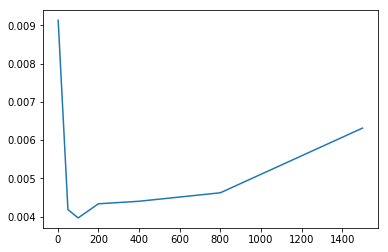

In [10]:
all_losses = np.array(all_losses)
plt.plot(all_losses[:, 0], all_losses[:, 1])

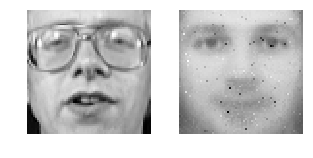

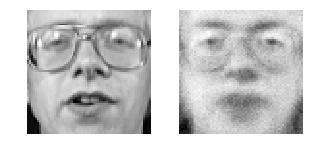

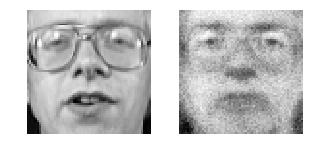

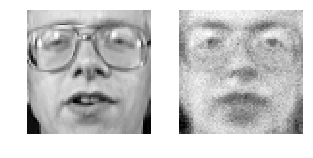

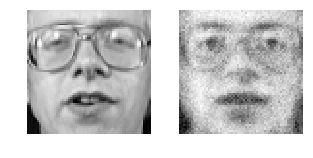

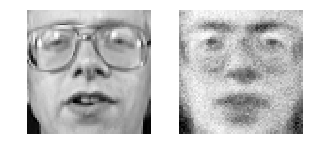

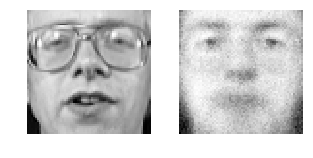

In [11]:
idx = 10

for i, encoder in enumerate(encoders):
    x_enc = encoder(Variable(torch.FloatTensor(data_[idx])))
    x_dec = decoders[i](x_enc)

    plt.figure(figsize=(5, 5))
    plt.subplot(2, 2, 1)
    plt.imshow(data_[idx].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
    plt.subplot(2, 2, 2)
    plt.imshow(np.array(x_dec.data).reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
    plt.show()

<i> 2.5 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют?</i>

In [13]:
encoder = nn.Sequential(nn.Linear(4096, 200), nn.Linear(200, 2))
decoder = nn.Sequential(nn.Linear(2, 200), nn.Linear(200, 4096))
params = list(encoder.parameters()) + list(decoder.parameters())
opt = optim.Adam(params=params, lr=0.001)
loss_func = nn.MSELoss()
epoch = 250
losses = []

for e in tqdm(range(epoch)):
    for batch in dataloader:
        x = Variable(torch.FloatTensor(batch))
        y = Variable(torch.FloatTensor(batch), requires_grad=False)

        x_pred = encoder(x)
        y_pred = decoder(x_pred)

        loss = loss_func(y_pred, y)
        losses.append(np.array(loss.data))
        opt.zero_grad()
        loss.backward()
        opt.step()

100%|██████████| 250/250 [00:27<00:00,  8.30it/s]


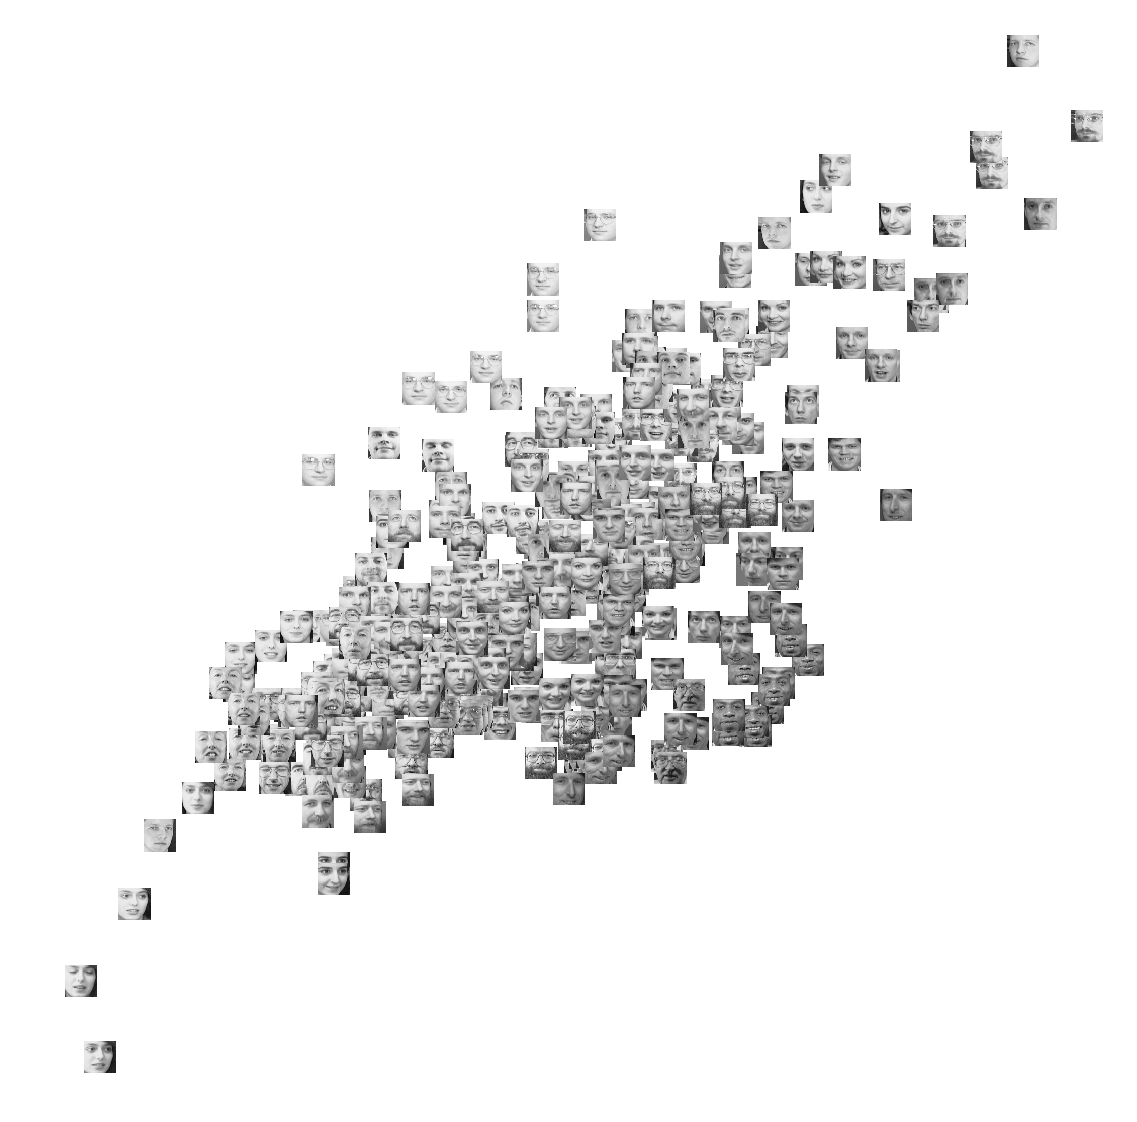

In [18]:
embed = np.array(encoder(torch.Tensor(X)).data)
plot_dataset(X, embed)

Снова, если рассматривать картинки близкие друг к другу, то они досататочно похожи, также може заметить, что слева направо лица людей меняют направление взгляда.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: